In [1]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import pickle

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt

sys.path.append('ComputableInformationDensity_dev')
from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from utils import timeit, get_allowed_time_intervals, block_flatten

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [4]:
# possibly extent to more activities

LX = 256
base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
d_cluster = dict(path = base_path + '_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_l = dict(path = base_path + 'l_cl', \
              suffix = "l_cl", priority = 1, LX = LX, Nframes = 400)
d_cluster_vl = dict(path = base_path + 'vl_cl', \
              suffix = "vl_cl", priority = 1, LX = LX, Nframes = 1500)
d_list = [d_cluster_l, d_cluster_vl]


## Choose which dataset to visualize
act = 0.028 #22
exp = 0

folder_path = os.path.join(base_path, f'analysis_zeta_{act}',  f'zeta_{act}_counter_{num_exp}')
defect_path = os.path.join(folder_path, 'defect_positions.pkl')

with open(defect_path, 'rb') as f:
    top_defects = pkl.load(f)


In [12]:
get_allowed_time_intervals(system_size = 256)

[{'time_interval': 4, 'nbits': 6},
 {'time_interval': 32, 'nbits': 7},
 {'time_interval': 256, 'nbits': 8}]

In [5]:
2**(3/2*(7-1))


512.0

In [73]:
development_mode = False
if development_mode:
    num_frames = 2
LY=LX

num_frames = len(top_defects)
nframes_to_analyze = 50
#nframes_tot = 50 # len(top_defects)
# --------------------------------------------
# Set params
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

overlap = 2
compression_factor = 4
nbits = 5
nshuffle = 8

observation_window_bounds = [(0, int(LX / compression_factor)), (0, int(LY / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

nframes_per_cube = get_allowed_time_intervals(system_size = lx_window, nbits_max=nbits)[-1]['time_interval']
time_subinterval = nframes_per_cube - overlap
ncubes = 1 + int(((nframes_to_analyze - nframes_per_cube) / time_subinterval))
first_frame_idx = (num_frames - nframes_to_analyze) + (nframes_to_analyze - nframes_per_cube - ((ncubes - 1) * time_subinterval))

param_dict = {
    'cid_mode' : cid_mode,
    'dtype' : dtype,
    'nshuffle' : nshuffle,
    'nbits' : nbits,
    'compression_factor' : compression_factor,
    'observation_window_bounds' : observation_window_bounds,
    'lx_window' : lx_window,
    'ly_window' : ly_window,
    'nframes_to_analyze' : nframes_to_analyze,
    'ncubes' : ncubes,
    'nframes_per_cube' : nframes_per_cube,
    'overlap' : overlap,
    'time_subinterval' : time_subinterval,
    'first_frame_idx' : first_frame_idx,     
}


print(f"Total number of frames: {nframes_to_analyze}")
print(f"Number of cubes: {ncubes}, number of frames per cube: {nframes_per_cube}")
print(f"First frame index: {first_frame_idx}")
print(f'Overlap: {overlap}, time subinterval: {time_subinterval}')

Total number of frames: 50
Number of cubes: 8, number of frames per cube: 8
First frame index: 131
Overlap: 2, time subinterval: 6


In [74]:
# Create defect grid and compute CID

defect_grid = np.zeros((num_frames - first_frame_idx, lx_window, ly_window), dtype=dtype)
defect_count = []

for i, defect in enumerate(top_defects[first_frame_idx:]):
    def_arr = get_defect_arr_from_frame(defect) #.astype(int)
    if def_arr is None:
        defect_count.append(0)
        continue
    def_arr = def_arr.astype(dtype)
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[1][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[1][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_grid[i, def_arr[:,0], def_arr[:,1]] = 1
    defect_count.append(defect_grid[i,:,:].sum())

In [70]:
time_subinterval, nframes_per_cube, defect_grid.shape

(6, 8, (50, 64, 64))

In [ ]:
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=True)

cid_arr = np.nan * np.ones((ncubes, 2))
cid_shuffle_arr = np.nan * np.ones((ncubes, 2))

for j in range(ncubes):
    data = defect_grid[j * time_subinterval:(j+1)*time_subinterval+overlap].ravel()
 
    cid_av, cid_std, cid_shuff = CID(data)
    cid_arr[j, 0] = cid_av
    cid_arr[j, 1] = cid_std
    cid_shuffle_arr[j, :] = cid_shuff


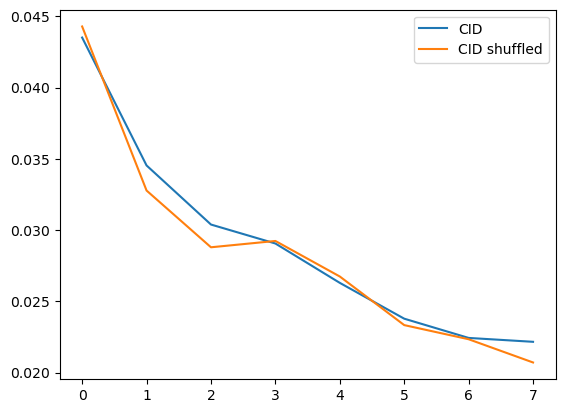

In [78]:
plt.plot(cid_arr[:,0], label='CID')
plt.plot(cid_shuffle_arr[:,0], label='CID shuffled')
plt.legend()

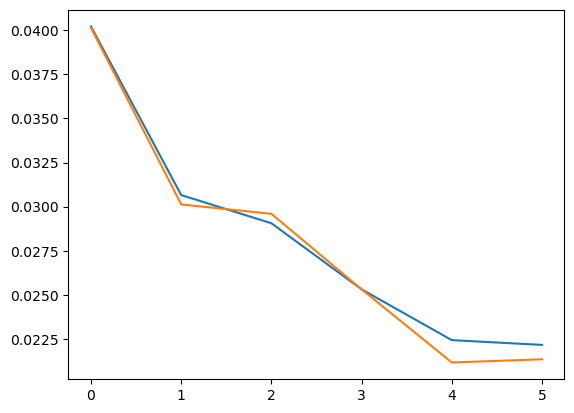

In [67]:
plt.plot(cid_arr[:,0], label='CID')
plt.plot(cid_shuffle_arr[:,0], label='CID shuffled')

In [ ]:
development_mode = False
if development_mode:
    num_frames = 2
LY=LX

nframes_tot = len(top_defects)
# --------------------------------------------
# Set params
dtype = np.uint8
cid_mode = 'lz77'
verbose = True

overlap = 0
compression_factor = 2
nbits = 5
nshuffle = 4

observation_window_bounds = [(0, int(LX / compression_factor)), (0, int(LY / compression_factor))]
lx_window = observation_window_bounds[0][1] - observation_window_bounds[0][0]
ly_window = observation_window_bounds[1][1] - observation_window_bounds[1][0]

nframes_per_cube = get_allowed_time_intervals(system_size = lx_window, nbits_max=12)[-1]['time_interval']



nbits_frame = int(np.log2(lx_window))

if not lx_window == ly_window:
    raise ValueError("Observation window must be square.")

allowed_intervals_list = get_allowed_time_intervals(system_size = lx_window, nbits_max=12)

# check that nframes is in allowed intervals
if nframes not in [ai['time_interval'] for ai in allowed_intervals_list]:
    raise ValueError(f"nframes {nframes} is not in allowed intervals {allowed_intervals_list}")
else:
    # get nbits for nframes
    nbits = [ai['nbits'] for ai in allowed_intervals_list if ai['time_interval'] == nframes][0]

param_dict = {
    'compression_factor' : compression_factor,
    'nshuffle' : nshuffle,
    'nframes' : nframes,
    'observation_window_bounds' : observation_window_bounds,
    'lx_window' : lx_window,
    'ly_window' : ly_window,
    'nbits_frame' : nbits_frame,
    'nbits' : nbits,
    'cid_mode' : cid_mode,
}

with open(os.path.join(output_path, f'cid_params_{cid_mode}.pkl'), 'wb') as f:
    pickle.dump(param_dict, f)

if verbose: print(f"Using nbits = {nbits} (size {1 << nbits}), nframes = {nframes}, nshuffle = {nshuffle}, window size {lx_window}x{ly_window}")

# --------------------------------------------
# Create defect grid and compute CID

defect_grid = np.zeros((nframes, lx_window, ly_window), dtype=dtype)
defect_count = []

for i, defect in enumerate(top_defects[-nframes:]):
    def_arr = get_defect_arr_from_frame(defect) #.astype(int)
    if def_arr is None:
        defect_count.append(0)
        continue
    def_arr = def_arr.astype(dtype)
    def_arr_xmask = (observation_window_bounds[0][0] < def_arr[:,0]) & (def_arr[:,0] < observation_window_bounds[0][1])
    def_arr_ymask = (observation_window_bounds[1][0] < def_arr[:,1]) & (def_arr[:,1] < observation_window_bounds[1][1])
    def_arr = def_arr[def_arr_xmask & def_arr_ymask]

    defect_grid[i, def_arr[:,0], def_arr[:,1]] = 1
    defect_count.append(defect_grid[i,:,:].sum())

if verbose: print(f"av defect counts in frames used for CID: {np.mean(defect_count):.2f}")  

t3 = time.perf_counter()
CID = interlaced_time(nbits=nbits, nshuff=nshuffle,mode=cid_mode, verbose=verbose)
cid_av, cid_std, cid_shuff = CID(defect_grid)

if verbose: print(f"For act,exp {act,exp}: CID/CID_shuff: {(cid_av/cid_shuff[0]):.4f} Time: ", np.round(time.perf_counter()-t3,2), "s")

res_cid = {
    'zeta' : ar.zeta,
    'density' : defect_count,
    'cid' : (cid_av,cid_std),
    'cid_shuffle' : cid_shuff,
    'lambda' : 1. - cid_av/cid_shuff[0]
}

#with open(os.path.join(output_path, f'cid_{cid_mode}.pkl'), 'wb') as f:
#    pickle.dump(res_cid, f)

#gen_status_txt(msg, os.path.join(output_path, 'cid_analysis_completed.txt'))